In [3]:
import os
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from retinaface import RetinaFace 
import matplotlib.pyplot as plt 
from torchvision import transforms
from PIL import Image , ImageOps
import random


In [4]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
images_dir = "Footballer_Datasets/train"
images_dir_footballers = os.listdir(images_dir)
data = []

for filename in images_dir_footballers:
    cls_name = filename.split("_",1)[0]
    data.append(cls_name)


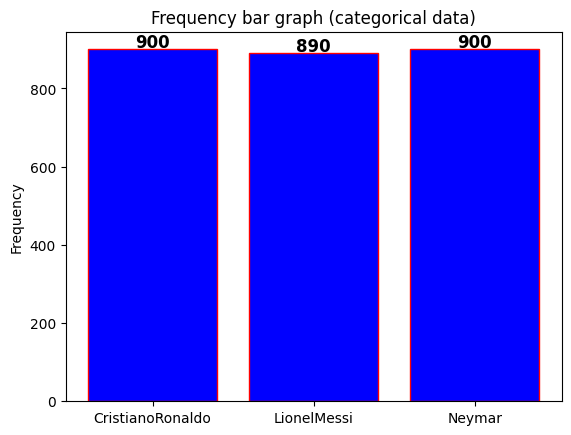

In [6]:
from collections import Counter 

#count occurences of each category 
frequency = Counter(data)

#extract the labels and the frequencies 
labels, counts = zip(*frequency.items())

#plotting the bargraph
plt.bar(labels, counts, color='blue', edgecolor='red')

#adding frequency labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v + 5, str(v), color ='black', ha ='center' , fontsize = 12 , fontweight='bold')

# plt.xticks(range(len(labels)),labels)

plt.ylabel("Frequency")
plt.title("Frequency bar graph (categorical data)")

plt.show()


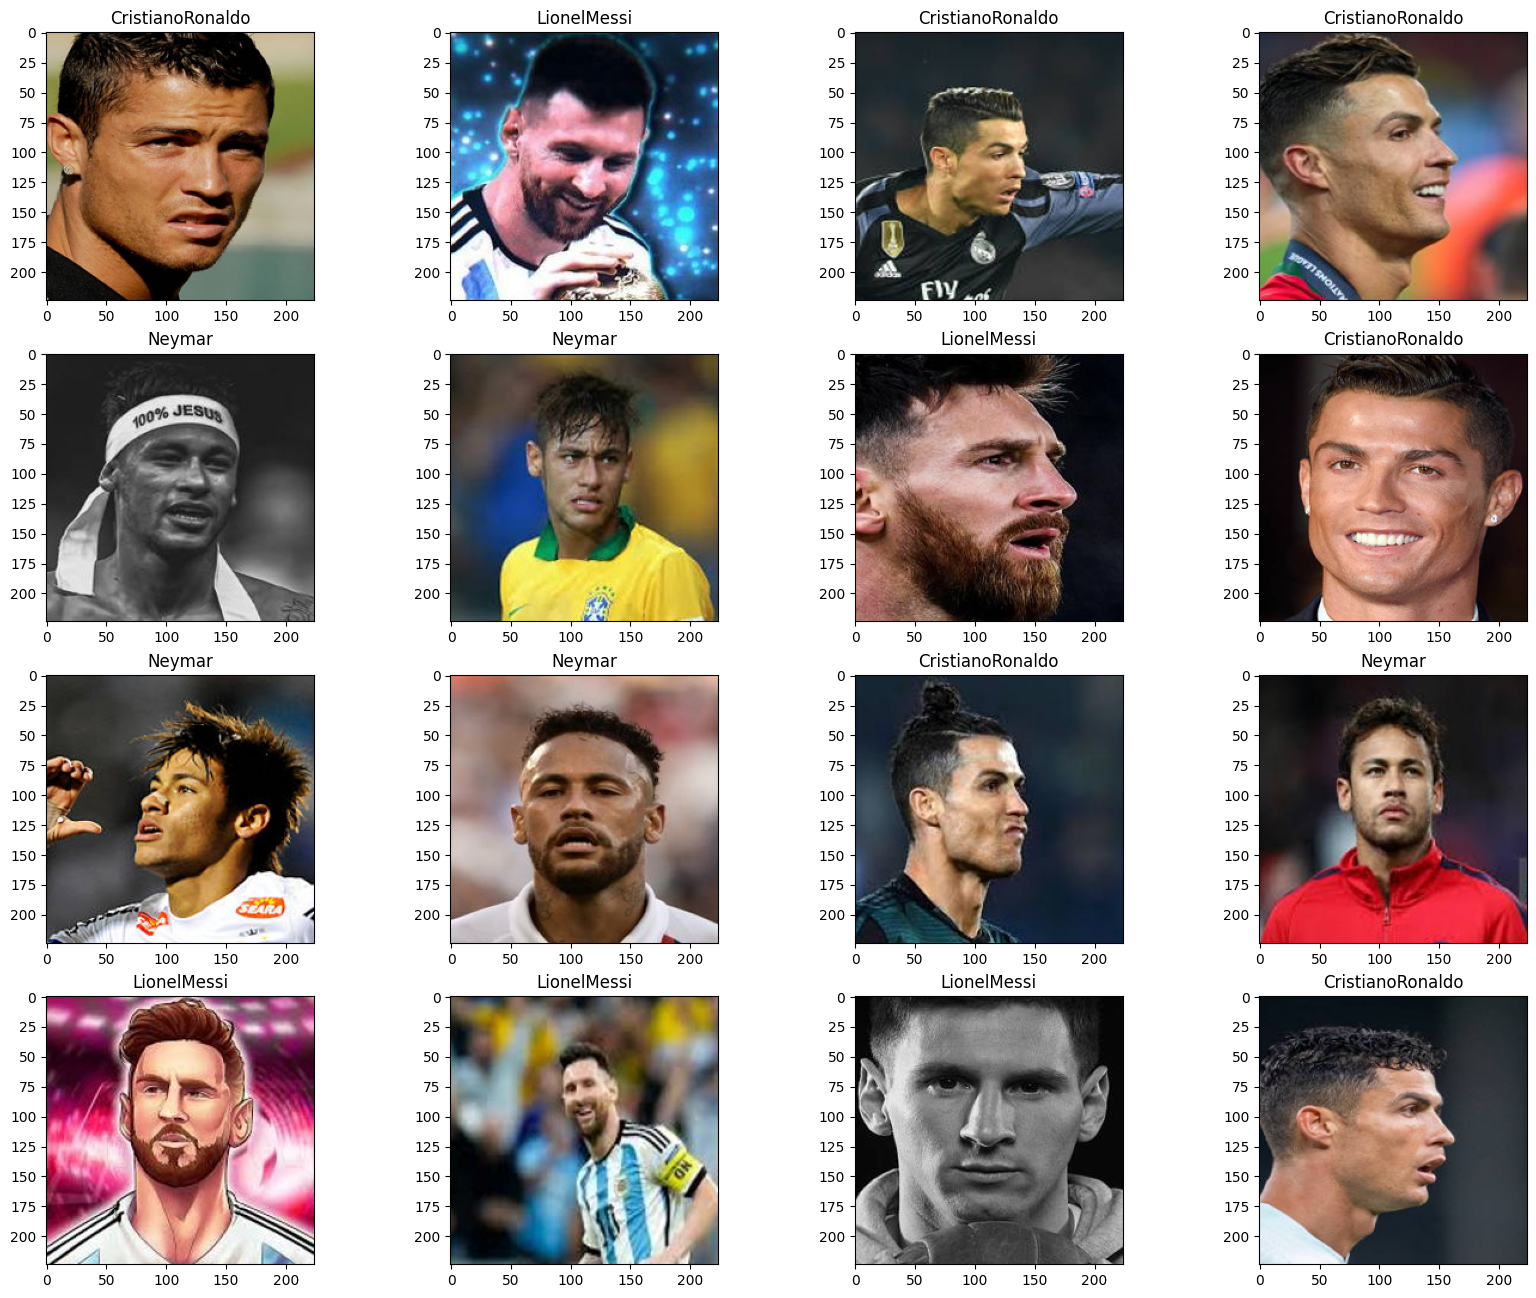

In [7]:
fig,ax = plt.subplots(4,4,figsize=(20,16))
ax = ax.ravel()

for i in range(16):
    images_name = random.choice(images_dir_footballers)
    img_path = os.path.join(images_dir,images_name)
    img = Image.open(img_path)
    cls_name = images_name.split("_",1)[0]
    ax[i].imshow(img)
    ax[i].set_title(cls_name)

In [8]:
transformation = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),#making sure that it's grayscale
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), #random crop and resize 
    transforms.RandomHorizontalFlip(p=0.5),# flip with 50 % probabilty 
    transforms.RandomRotation(15),#rotating up to 15 degrees
    transforms.RandomAffine(degrees = 0 , translate = (0.1, 0.1), shear = 10), #small shifts and shearing 
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1,2.0)),#adding slight blur for robustness
    transforms.ToTensor(), #converting to tensors
    transforms.Normalize(mean=[0.5] , std=[0.5]) #normalizing the grayscale image
])

#Creating the datasets class

In [9]:
class data():
    def __init__(self, dir , dir_files, transforms=None):
        self.dir = dir
        self.dir_files = dir_files
        self.transforms = transforms 

    def __len__(self):
        return len(self.dir_files)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.dir,self.dir_files[idx])
        img = Image.open(img_path)
        img = ImageOps.grayscale(img)

        cls_name = self.dir_files[idx].split("_",1)[0]
        if cls_name == "CristianoRonaldo":
            label = 0 
        elif cls_name == "LionelMessi":
            label = 1
        else :
            label = 2

        if self.transforms is not None:
            img = self.transforms(img)

        return (img,label)

#Creating Training Object 

In [10]:
dir_files = os.listdir(images_dir)
train = data(images_dir,dir_files,transformation)

#Creating the datasets 

In [11]:
from torch.utils.data import DataLoader, random_split 

#assume 'train' is your dataset (not a Dataloader)

dataset_size = len(train) #get datset size
print(dataset_size)
train_size = int(0.8 * dataset_size) #80% data taken for training
val_size = dataset_size - train_size #20% data taken for validation

#splitting the dataset 
train_dataset, val_dataset = random_split(train, [train_size, val_size])

#creating dataloaders 
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle= True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle= False)

#printing the dataset sizes
print(f"Training Size:{len(train_dataset)}")
print(f"Validation Size:{len(val_dataset)}")


2690
Training Size:2152
Validation Size:538


# Getting the shape 

In [12]:
print(train.__getitem__(0)[0].shape)

torch.Size([1, 224, 224])


In [15]:
print(len(train_dataset))
print(len(train_dataloader))

2152
68


# Plotting the images 

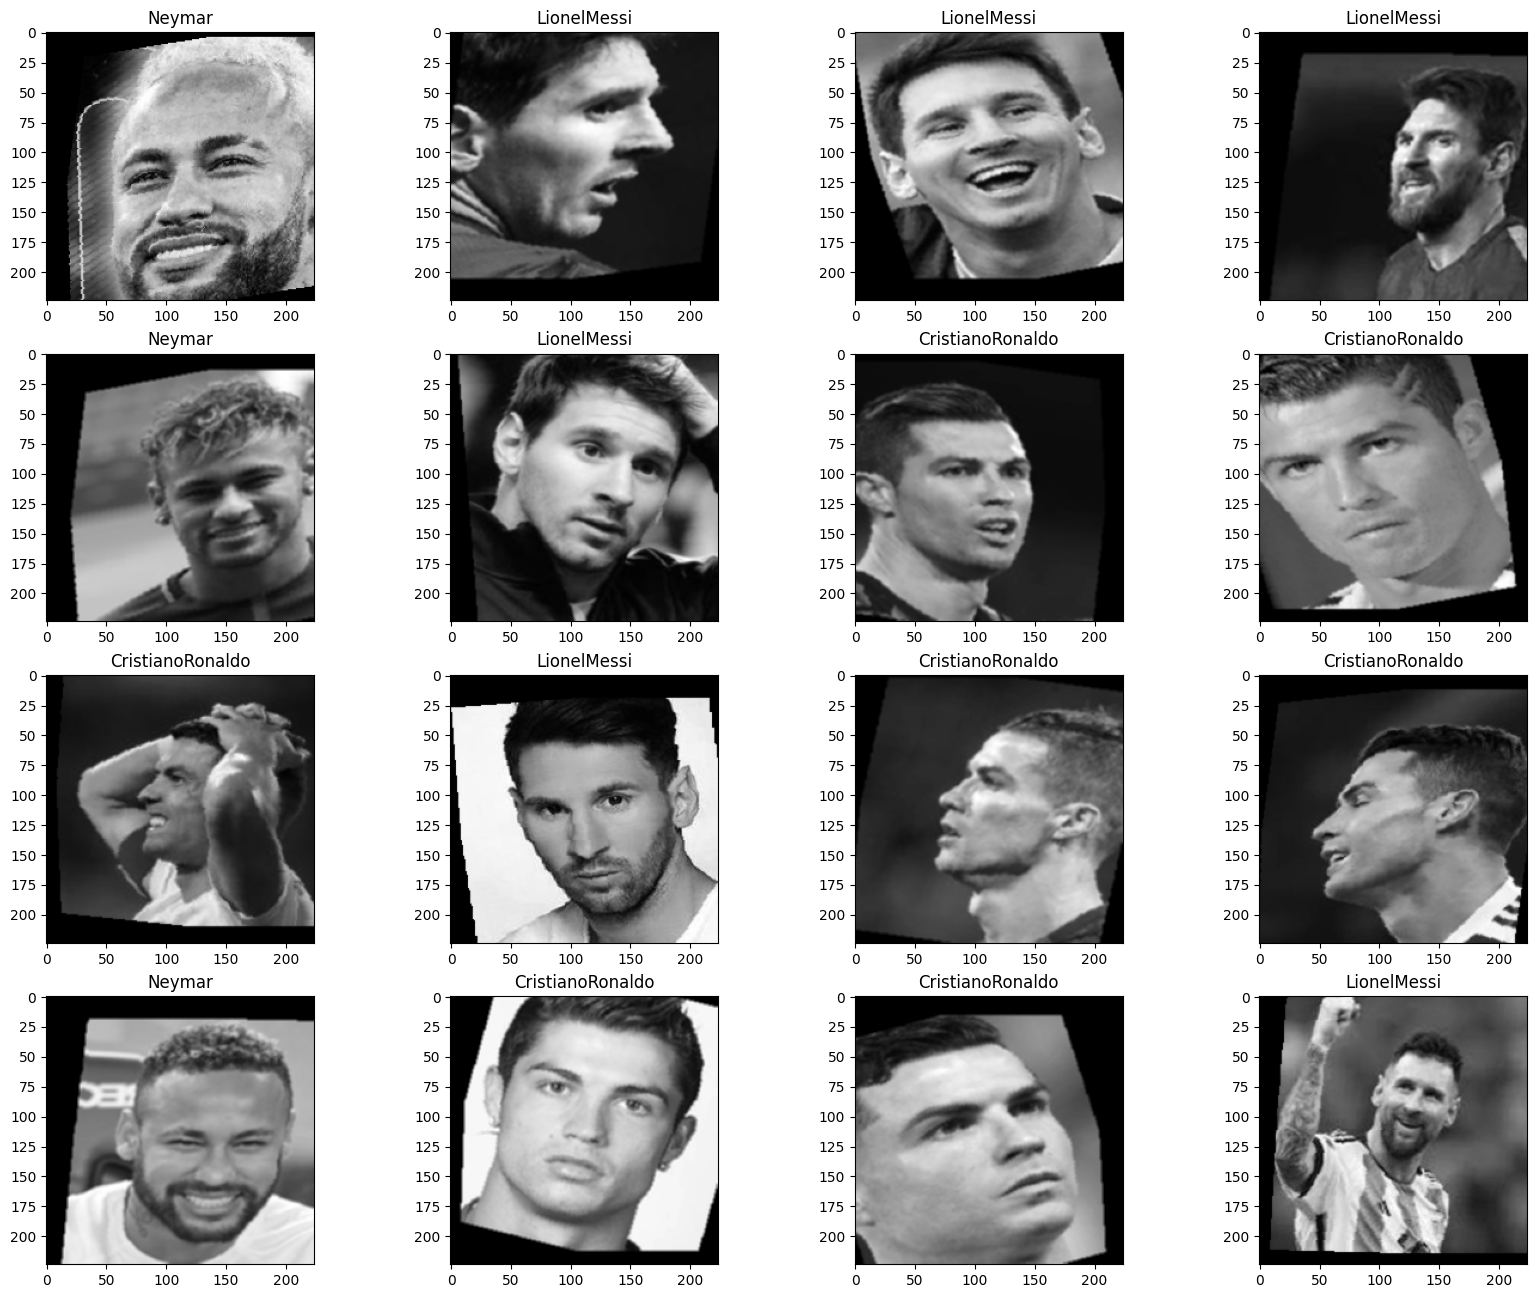

In [17]:
samples,labels = next(iter(train_dataloader))

fig, axes = plt.subplots(4,4,figsize=(20,16))
axes = axes.ravel()

class_names = {0:'CristianoRonaldo' ,1:'LionelMessi' , 2:'Neymar'}

for i in range(4*4):
    axes[i].imshow(samples[i].permute(1,2,0),cmap="gray") # (C,H,W) to (H,W,C)
    #print
    axes[i].set_title(class_names[labels[i].item()])


# Creating the CNN model 

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.batch1 = nn.BatchNorm2d(num_features=16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.batch2 = nn.BatchNorm2d(num_features=32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.batch3 = nn.BatchNorm2d(num_features=64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.batch4 = nn.BatchNorm2d(num_features=128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3)
        self.batch5 = nn.BatchNorm2d(num_features=512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=5*5*512, out_features=1024)
        self.fc1_batch = nn.BatchNorm1d(num_features=1024)

        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc2_batch = nn.BatchNorm1d(num_features=256)

        self.fc3 = nn.Linear(in_features=256, out_features=128)
        self.fc3_batch = nn.BatchNorm1d(num_features=128)

        self.fc4 = nn.Linear(in_features=128, out_features=3)

        self.softmax = nn.Softmax(dim = 1)

        
    def forward(self,x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.batch3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.batch4(x)
        x = F.relu(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.batch5(x)
        x = F.relu(x)
        x = self.pool5(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.fc1_batch(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = self.fc2_batch(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = self.fc3_batch(x)
        x = F.relu(x)

        x = self.fc4(x)
        x = self.softmax(x)

        return x
    

model = CNN().to(device)

# Getting the model's summary 

In [21]:
from torchsummary import summary 
summary(model,(1,224,224)) #(C,H,W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             160
       BatchNorm2d-2         [-1, 16, 222, 222]              32
         MaxPool2d-3         [-1, 16, 111, 111]               0
            Conv2d-4         [-1, 32, 109, 109]           4,640
       BatchNorm2d-5         [-1, 32, 109, 109]              64
         MaxPool2d-6           [-1, 32, 54, 54]               0
            Conv2d-7           [-1, 64, 52, 52]          18,496
       BatchNorm2d-8           [-1, 64, 52, 52]             128
         MaxPool2d-9           [-1, 64, 26, 26]               0
           Conv2d-10          [-1, 128, 24, 24]          73,856
      BatchNorm2d-11          [-1, 128, 24, 24]             256
        MaxPool2d-12          [-1, 128, 12, 12]               0
           Conv2d-13          [-1, 512, 10, 10]         590,336
      BatchNorm2d-14          [-1, 512,

# Defining Optimizers 

In [22]:
criterian = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
epochs = 100

# Model training

In [23]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

highest_val_loss = float('inf')

#directory to save the models 
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

#Define learning rate scheduler 
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

for epoch in range(epochs):
    model.train()
    correct = 0 
    train_running_loss = 0.0

    for data,labels in train_dataloader:
        data,labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterian(output, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()

        _,pred = torch.max(output,1)

        correct += (pred == labels).sum().item()

    epoch_train_loss = train_running_loss/len(train_dataloader)
    epoch_train_accuracy = (100 * correct)/len(train_dataset)
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)

    print(f'Epoch: {epoch+1}, Training loss: {epoch_train_loss}, Training accuracy: {epoch_train_accuracy}')

    with torch.no_grad():
        model.eval()
        correct = 0 
        val_running_loss = 0.0
        for val_data , val_labels in val_dataloader:
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            val_output = model(val_data)
            val_loss_value = criterian(val_output, val_labels)

            val_running_loss += val_loss_value.item()
            _,val_pred = torch.max(val_output,1)
            correct += (val_pred == val_labels).sum().item()
                
        epoch_val_loss = val_running_loss/len(val_dataloader)
        epoch_val_accuracy = (100 * correct)/len(val_dataset)
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_accuracy)

        print(f'Epoch: {epoch+1}, Validation loss: {epoch_val_loss}, Validation accuracy: {epoch_val_accuracy}')

        #Model Checkpoint : we need to save the best model based on validation loss 
        if epoch_val_loss < highest_val_loss :
            highest_val_loss = epoch_val_loss
            checkpoint_path = os.path.join(checkpoint_dir, f"best_model.pth")
            torch.save(model, checkpoint_path)
            print(f"Best model saved at {checkpoint_path} with validation loss = {epoch_val_loss:.4f}")


            #updateing learning rate
    scheduler.step()
    print(f"Updated learning rate : {scheduler.get_last_lr()[0]:.6f}\n")

    print("\n")



Epoch: 1, Training loss: 1.0002499608432545, Training accuracy: 52.88104089219331
Epoch: 1, Validation loss: 0.8945254858802346, Validation accuracy: 64.49814126394052
Best model saved at checkpoints\best_model.pth with validation loss = 0.8945
Updated learning rate : 0.000976



Epoch: 2, Training loss: 0.9063215071664137, Training accuracy: 63.38289962825279
Epoch: 2, Validation loss: 0.8950814780066995, Validation accuracy: 64.31226765799256
Updated learning rate : 0.000905



Epoch: 3, Training loss: 0.8650930269676096, Training accuracy: 67.28624535315986
Epoch: 3, Validation loss: 0.8533064267214607, Validation accuracy: 68.77323420074349
Best model saved at checkpoints\best_model.pth with validation loss = 0.8533
Updated learning rate : 0.000794



Epoch: 4, Training loss: 0.8304667481604744, Training accuracy: 70.91078066914498
Epoch: 4, Validation loss: 0.8254333909820107, Validation accuracy: 72.67657992565056
Best model saved at checkpoints\best_model.pth with validation los

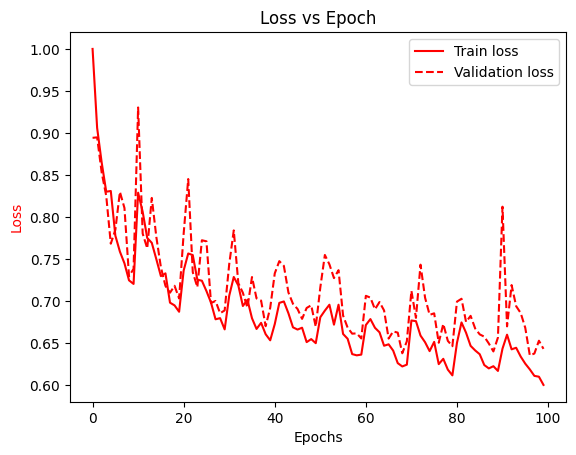

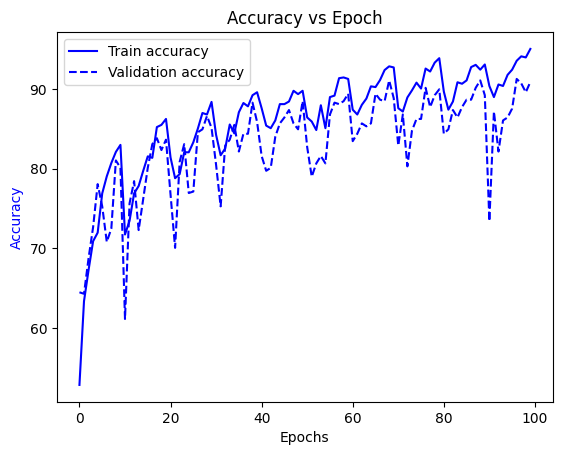

In [24]:
epoch_log = [*range(epochs)]

fig,ax1 = plt.subplots()
ax1.plot(epoch_log,train_loss,'r-',label = 'Train loss')
ax1.plot(epoch_log,val_loss,'r--',label = 'Validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss',color='r')
ax1.set_title('Loss vs Epoch')
ax1.legend()
plt.show()

print("\n")

fig,ax2 = plt.subplots()
ax2.plot(epoch_log,train_accuracy,'b-',label = 'Train accuracy')
ax2.plot(epoch_log,val_accuracy,'b--',label = 'Validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy',color='b')
ax2.set_title('Accuracy vs Epoch')
ax2.legend()
plt.show()

# Loading Model

In [28]:
# Initialize the model before loading weights
model = CNN()  # Ensure MyModel is defined
#model.load_state_dict(torch.load("checkpoints/best_model.pth"))  # Load state_dict into the model
model = torch.load("checkpoints/best_model.pth",weights_only=False)
model.to(device)  # Move model to GPU or CPU
model.eval()  # Set to evaluation mode

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 512, kernel_siz

In [43]:
def detect_and_crop_face(image_path):
    """Detects a face in an image, crops it, and resizes it to 224x224."""
    image = Image.open(image_path)
    faces = RetinaFace.detect_faces(image_path)

    if len(faces) >= 2:
        print(f"Multiple faces detected in {image_path}, skipping...")
        return None
    elif len(faces) == 0:
        print(f"No face detected in {image_path}, skipping...")
        return None

    # print(faces)
    key = list(faces.keys())[0]
    face = faces[key]
    x1, y1, x2, y2 = face["facial_area"]

    # Expand bounding box
    expansion = 60
    x1 = max(0, x1 - expansion)
    y1 = max(0, y1 - expansion)
    x2 = min(image.size[1], x2 + expansion)
    y2 = min(image.size[0], y2 + expansion)

    # Crop and resize face
    face_crop = image.crop((x1, y1, x2, y2))
    face_resized = face_crop.resize((224, 224))

    return face_resized

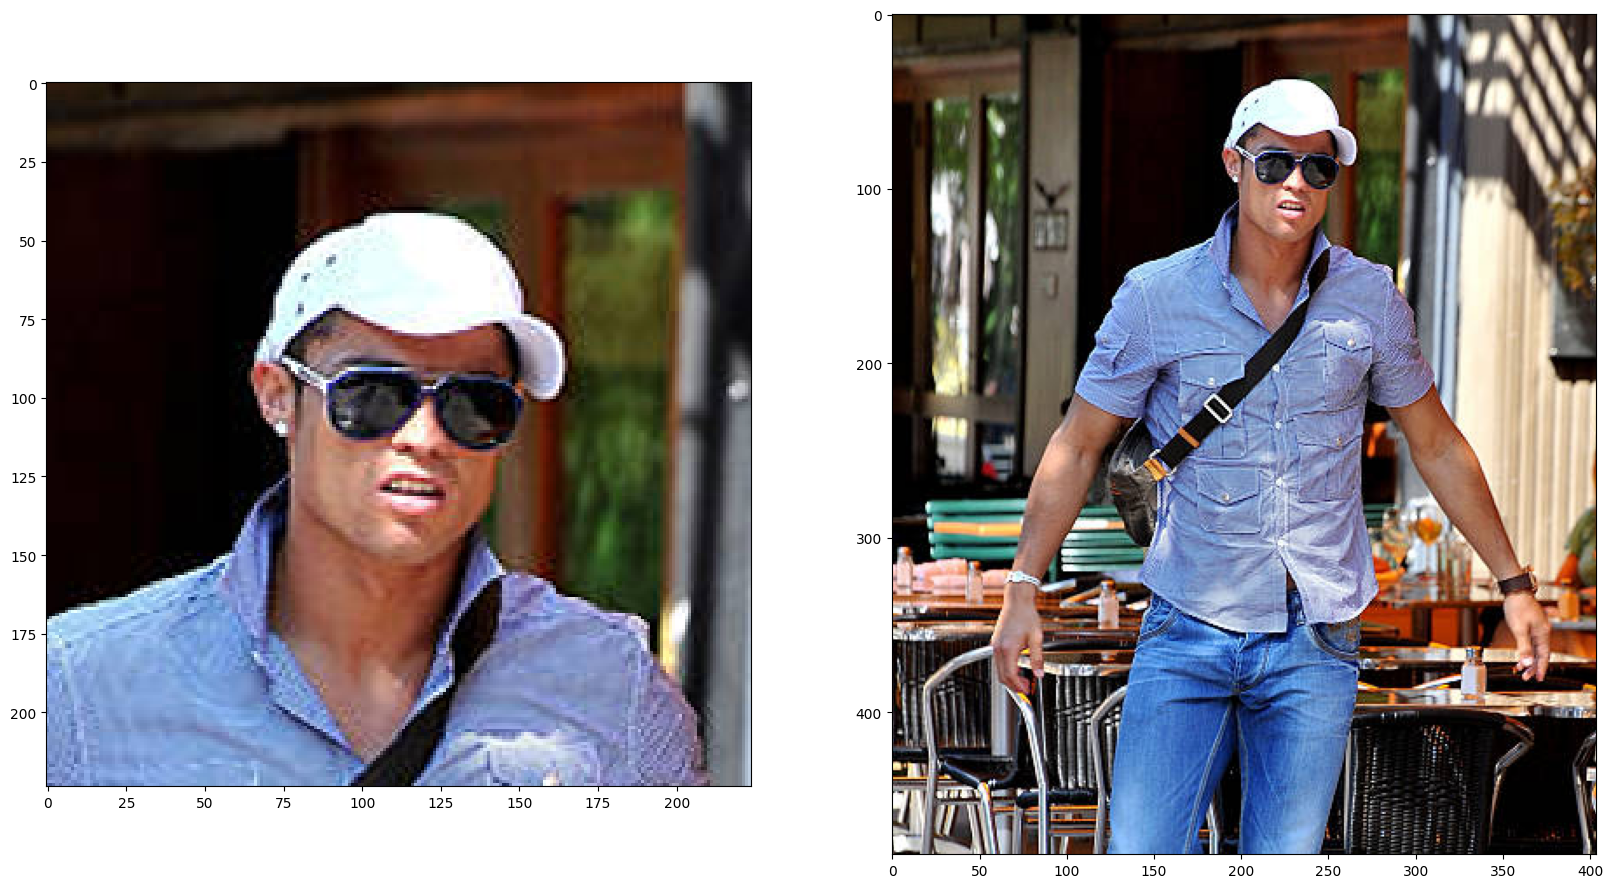

In [44]:
fig,axes = plt.subplots(1,2,figsize=(20,22))
axes = axes.ravel()

test_dir= 'Footballer_Datasets/test'
test_filenames = os.listdir(test_dir)
img_path = os.path.join(test_dir, random.choice(test_filenames))
preprocessed_img = detect_and_crop_face(img_path)
axes[0].imshow(preprocessed_img)
image = Image.open(img_path)
axes[1].imshow(image)
plt.show()

Multiple faces detected in Footballer_Datasets/test\CFLO5FivC5sN.png, skipping...
Multiple faces detected in Footballer_Datasets/test\QQ3miLoIfwGI.png, skipping...


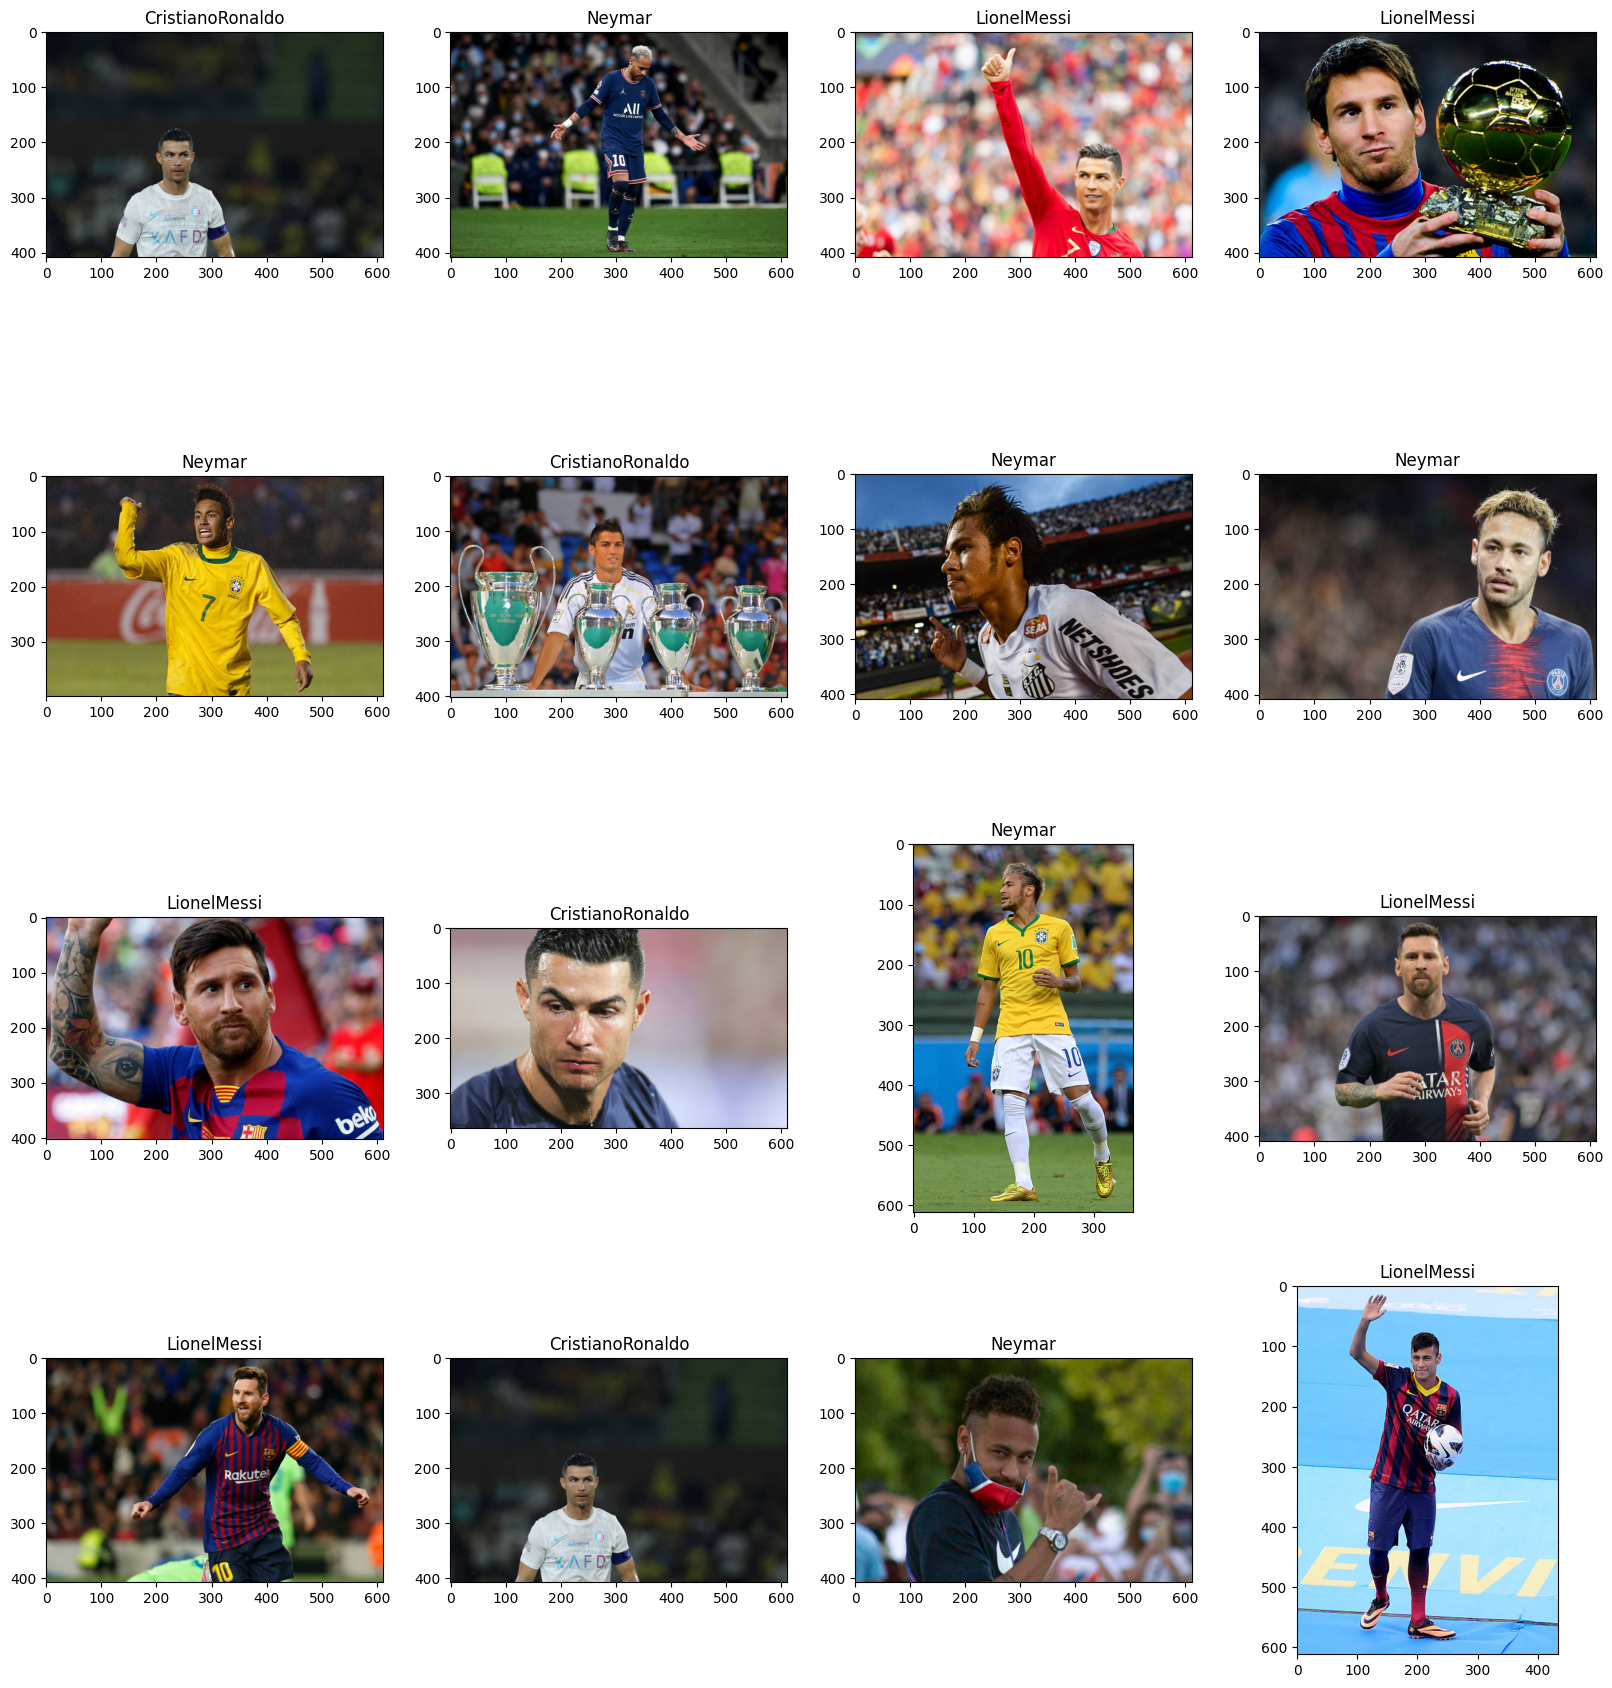

In [45]:
test_dir = 'Footballer_Datasets/test'
test_filenames = os.listdir(test_dir)

images = []
def preprocessing(image):
    img = transformation(image)
    img = img.unsqueeze(0)
    return img

fig,axes = plt.subplots(4,4,figsize=(20,22))
axes = axes.ravel()

i = 0

while (i < 16 ):
    img_path = os.path.join(test_dir,random.choice(test_filenames))
    preprocessed_img = detect_and_crop_face(img_path)
    if preprocessed_img is None:
        continue
    preprocessed_img = ImageOps.grayscale(preprocessed_img)
    preprocessed_img = preprocessing(preprocessed_img)
    preprocessed_img = preprocessed_img.to(device)

    output = model(preprocessed_img)
    pred = torch.argmax(output).item()
    label = class_names[pred]

    image = Image.open(img_path)
    
    axes[i].imshow(image)
    axes[i].set_title(label)
    i += 1

plt.show()

